In [9]:
TRAIN_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/spgc/views"
VALIDATION_IMG_SRC_FOLDER = "/home/guilherme/Documents/noa/cidia19/data/spgc/views"

# SUB_FILE = ['axis1', 'axis2']
SUB_FILE = ['axis2']


EPOCHS = 1 #50
IMG_HEIGHT = 32 #448
IMG_WIDTH = 32 #448
IMG_CHANNELS = 3
SELECTED_MODEL = ''
NUM_CLASSES = 2
DATA_FOLDER = 'spgc-binario-42img/'
LOG_FOLDER = 'logs/' + DATA_FOLDER
TRAINING_FOLDER = 'training/' + DATA_FOLDER
MODEL_FOLDER = 'models/' + DATA_FOLDER
IMAGE_FOLDER = 'images/' + DATA_FOLDER

STRUCTURE_DATASET_FOLDER = "csv/input/"+DATA_FOLDER
OUTPUT_PREDICTED_FOLDER = "csv/output/" + DATA_FOLDER
COLUMN_TARGET = 'ternario'





import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import glob
import os
from datetime import datetime

import tensorflow as tf
import utilities.plot_metrics as pm



def get_file_path(folder, search_filter=''):
    '''
    Get all files (full path) contained in a PATH folder by specified search filter 
    '''
    paths = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            path = os.path.join(root, file)
            if search_filter in path:
                paths.append(path)
    return paths

def get_data_set(fold_number, cur_subfile, data_train, data_test):
    ''' Creates and returns a dataframe with all the full paths (for slice) for train and test images. 
    Save it as log. 
    '''
    dfs = []
    train_images = {"id": [], "label": []}
    validation_images = {"id": [], "label": []}
    
    
    TRAIN_IMG_FOLDERS_SLICE = {}
    for _, row in data_train.iterrows():
        TRAIN_IMG_FOLDERS_SLICE[row['nome']] = row[COLUMN_TARGET]

    VALIDATION_IMG_FOLDERS_SLICE = {}
    for _, row in data_test.iterrows():
        VALIDATION_IMG_FOLDERS_SLICE[row['nome']] = row[COLUMN_TARGET]
    
    df_config = [
        (TRAIN_IMG_SRC_FOLDER, TRAIN_IMG_FOLDERS_SLICE, train_images),
        (VALIDATION_IMG_SRC_FOLDER, VALIDATION_IMG_FOLDERS_SLICE, validation_images)
    ]
    for (base, folder, dic) in df_config:
        for img_folder, img_label in folder.items():
            search_folder = "{}/{}".format(base, img_folder)
            imgs_filename = sorted(get_file_path(search_folder, search_filter = cur_subfile))
            dic["id"].extend(imgs_filename)
            dic["label"].extend([img_label] * len(imgs_filename))

        dfs.append(pd.DataFrame(data=dic))
#     print(dfs)
    train_df, validation_df = dfs[0], dfs[1]


    if not os.path.exists("logs/"): 
        os.mkdir("logs/")
    if not os.path.exists(LOG_FOLDER): 
        os.mkdir(LOG_FOLDER)
        
    train_df.to_csv("{}/train{}.csv".format(LOG_FOLDER, fold_number), index=False)
    validation_df.to_csv("{}/test{}.csv".format(LOG_FOLDER, fold_number), index=False)

    print("Train fold with {} images".format(len(train_df)))
    print(train_df.groupby("label").label.count())
    print()
    print("Validation fold with {} images".format(len(validation_df)))
    print(validation_df.groupby("label").label.count())
    print("-" * 30)
    return (train_df, validation_df)


    
def get_data_generator(dataframe, x_col, y_col, subset=None, shuffle=True, batch_size=32, class_mode="binary"):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.05,
    horizontal_flip=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )
    
    data_generator = datagen.flow_from_dataframe(
        dataframe=dataframe,
        x_col=x_col,
        y_col=y_col,
        subset=subset,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        class_mode=class_mode,
        # color_mode="rgb",
        batch_size=batch_size,
        shuffle=shuffle
    )
    return data_generator

In [10]:
def get_base_model():
    base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    return base_model


def get_model_densenet121():
    with tf.device('/GPU:0'):
        conv_base = get_base_model()
        conv_base.trainable = True

        x = conv_base.output
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        '''Added'''
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
        x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        preds = tf.keras.layers.Dense(units=NUM_CLASSES, activation = 'softmax')(x)
        
        model = tf.keras.Model(inputs=conv_base.input, outputs=preds)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5),
                      loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return (model, 'densenet121')




Fold 
Train fold with 7056 images
label
covid     4872
normal    2184
Name: label, dtype: int64

Validation fold with 3318 images
label
covid     2310
normal    1008
Name: label, dtype: int64
------------------------------

axis2
=====
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_2[0][0]           
___________________________________________________

882/882 [==============================] - ETA: 0s - loss: 0.8395 - accuracy: 0.5866
Epoch 00001: val_accuracy improved from -inf to 0.63255, saving model to training/spgc-binario-42img//densenet121/fold/axis2//my_checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: training/spgc-binario-42img//densenet121/fold/axis2//my_checkpoint/assets
882/882 [==============================] - 98s 111ms/step - loss: 0.8395 - accuracy: 0.5866 - val_loss: 0.9013 - val_accuracy: 0.6325
{'covid': 0, 'normal': 1}


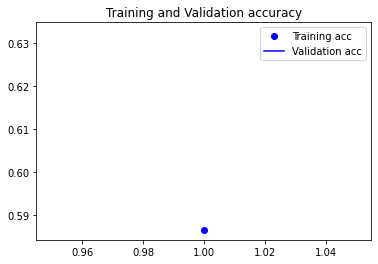

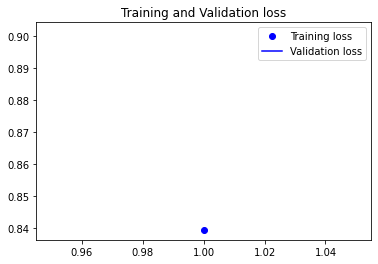

In [11]:
def train_model(model, train_df, validation_df, epochs, fold='', axis=''):
    batch_size = 8
    train_generator = get_data_generator(train_df, "id", "label", batch_size=batch_size, class_mode="categorical")
    validation_generator = get_data_generator(validation_df, "id", "label", batch_size=batch_size, class_mode="categorical")

    print(train_generator.class_indices)
    print(validation_generator.class_indices)
    
    step_size_train = train_generator.n // train_generator.batch_size
    step_size_validation = validation_generator.n // validation_generator.batch_size

    if step_size_train == 0:
        step_size_train = train_generator.n // 2
        step_size_validation = validation_generator.n // 2
        
        
    # callbacks, save each time
    # training/20200827/vgg16/fold4/axis2
    checkpoint_path = "training/"
    if not os.path.exists("training/"): 
        os.mkdir("training/")
    checkpoint_path = "{}/".format(TRAINING_FOLDER)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    checkpoint_path = "{}/{}/fold{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
    
    checkpoint_path = "{}/{}/fold{}/{}/".format(TRAINING_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(checkpoint_path): 
        os.mkdir(checkpoint_path)
        
    # Save dict results of history and legend from current model
    # models/20200827/vgg16/fold4/axis2/{history|legend}
    if not os.path.exists("models/"): 
        os.mkdir("models/")
    
    model_dir = "{}/".format(MODEL_FOLDER)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}".format(MODEL_FOLDER, SELECTED_MODEL)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
        
    model_dir = "{}/{}/fold{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
    model_dir = "{}/{}/fold{}/{}/".format(MODEL_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(model_dir): 
        os.mkdir(model_dir)
    
#     checkpoint_path = checkpoint_path + "/cp-{epoch:04d}.ckpt"
    checkpoint_path = checkpoint_path +"/my_checkpoint"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights every 25 epochs
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=1,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )
        
    history = model.fit(train_generator, # X_Train
        steps_per_epoch=step_size_train,
        epochs=epochs, 
        validation_data=validation_generator,
        validation_steps=step_size_validation,
        callbacks=cp_callback
                       )
    
    # Save last values
#     model.save_weights(checkpoint_dir+"/my_checkpoint")
    # model.save(checkpoint_dir+"/my_checkpoint")
    
    # Save history
    hist_df = pd.DataFrame(history.history) 
    hist_csv_file = model_dir + 'history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    
    # Save classes
    print(train_generator.class_indices)
    np.save(model_dir + 'legend', train_generator.class_indices)
    return history.history



def plot_results(history, sub_folder, fold, sel_model):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    
    image_dir = "images/"
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/".format(IMAGE_FOLDER)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    image_dir = "{}/{}/fold{}/{}/".format(IMAGE_FOLDER, SELECTED_MODEL, fold, axis)
    if not os.path.exists(image_dir): 
        os.mkdir(image_dir)
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and Validation accuracy')
    plt.legend()
    plt.savefig(image_dir + 'accuracy', pad_inches=0.1)
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    
    plt.savefig(image_dir + 'loss', orientation='portrait', pad_inches=0.1)

    plt.show()
    
    

data_train = pd.read_csv("{}/validation/validation{}.csv".format(STRUCTURE_DATASET_FOLDER, ''))
labels = data_train[COLUMN_TARGET].unique()

labels.sort()
labels_length = len(labels)
labels_pos_dict = dict(zip(labels, [i for i in range(labels_length)]))

for axis in SUB_FILE:
    
    ''' CREATE PATHS FOR SAVE OUTPUT '''
    predicted_dir = "{}/".format(OUTPUT_PREDICTED_FOLDER)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    predicted_dir = "{}/{}/".format(OUTPUT_PREDICTED_FOLDER, axis)
    if not os.path.exists(predicted_dir): 
        os.mkdir(predicted_dir)
    ''''''
    
    ''' CREATE DATAFRAME AND CONFUSION MATRIX - ACCUMULATED '''
    # Predicted class for patient and fold
    df_axis = pd.DataFrame(columns=['fold', 'patient', 'real', 'predicted', 'count'])
    # Generate confusion matrix
    confusion_matrix = np.zeros(labels_length*labels_length).reshape(labels_length, labels_length)
    ''''''
    
#     for n_fold in [2, 3, 4]:
    # for n_fold in [j+1 for j in range(5)]:
    for n_fold in ['']:
        print("\n\n\nFold", str(n_fold))
        
        data_train = pd.read_csv("{}/train/train{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        data_validation = pd.read_csv("{}/validation/validation{}.csv".format(STRUCTURE_DATASET_FOLDER, n_fold))
        train_df, validation_df = get_data_set(n_fold, axis, data_train, data_validation)
        data_validation_dict = dict(zip(data_validation['nome'], data_validation[COLUMN_TARGET]))
        
        print('\n'+axis+'\n=====')
#         model, SELECTED_MODEL = get_model_resnet101()
        model, SELECTED_MODEL = get_model_densenet121()
        history = train_model(model, train_df, validation_df, EPOCHS, n_fold, axis)
        
        #Plot Results
        plot_results(history, axis, n_fold, SELECTED_MODEL)
        # Load legend
        legend_path = "{}/{}/fold{}/{}/legend".format(MODEL_FOLDER, SELECTED_MODEL, n_fold, axis)
